## Explore data

In [1]:
import pandas as pd 
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
import torch
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

%matplotlib inline

path2csv="./histopathologic-cancer-detection/train_labels.csv"
path2train="./histopathologic-cancer-detection/train/"
labels_df=pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


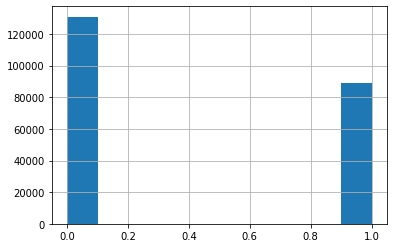

In [2]:
labels_df['label'].hist();


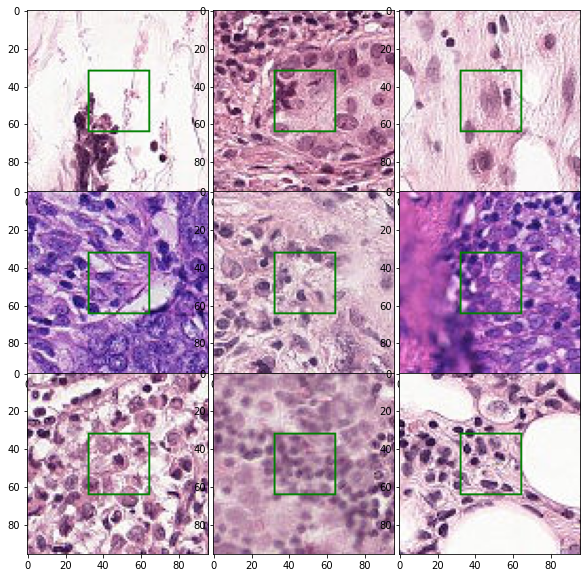

In [3]:
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train , id_ +'.tif')
 
    # load image
    img = Image.open(full_filenames)

    # draw a 32*32 rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")

    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))

Create custom dataset. 

In [4]:
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # path to images
        path2data=os.path.join(data_dir,data_type)

        # get list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        path2csvLabels=os.path.join(data_dir,"train_labels.csv")
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform
      
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [5]:
data_transformer = transforms.Compose([transforms.ToTensor()])
data_dir = "./histopathologic-cancer-detection/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))


220025


## Split data
Validation dataset to track models performance in training. 80/20 split

In [6]:
len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))


train dataset length: 176020
validation dataset length: 44005


## Transform
Expand our dataset and achieve greater regularization results for final model by doing transformations.

In [7]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])
val_transformer = transforms.Compose([transforms.ToTensor()])

train_ds.transform=train_transformer
val_ds.transform=val_transformer

## Create Dataloader

In [8]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)


# Define model
CNN - 4 * ConV -2 * FC

In [9]:
def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)


class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [18]:
params_model={
        "input_shape": (3,96,96),
        "initial_filters": 8,    
        "num_fc1": 50,
        "dropout_rate": 0.25,
        "num_classes": 2,
            }
net = Net(params_model)


## Define loss and optimization algorithm
For loss we will do cross-entropy.

tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1])


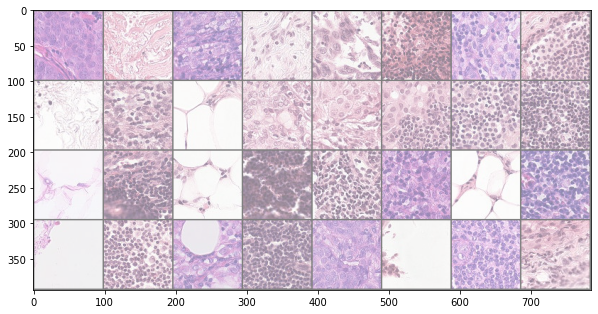

In [19]:
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(net.parameters(), lr=0.001)
dataiter = iter(train_dl)
images, labels = dataiter.next()
print(labels)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(utils.make_grid(images))

## Train and evaluate

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


[1,   200] loss: 19.952
[1,   400] loss: 16.379
[1,   600] loss: 15.912
[1,   800] loss: 15.450
[1,  1000] loss: 15.076
[1,  1200] loss: 14.960
[1,  1400] loss: 14.895
[1,  1600] loss: 14.850
[1,  1800] loss: 14.640
[1,  2000] loss: 14.515
[1,  2200] loss: 14.278
[1,  2400] loss: 14.313
[1,  2600] loss: 14.019
[1,  2800] loss: 13.906
[1,  3000] loss: 13.574
[1,  3200] loss: 13.448
[1,  3400] loss: 13.666
[1,  3600] loss: 13.434
[1,  3800] loss: 13.257
[1,  4000] loss: 13.067
[1,  4200] loss: 12.472
[1,  4400] loss: 13.076
[1,  4600] loss: 12.852
[1,  4800] loss: 12.469
[1,  5000] loss: 12.087
[1,  5200] loss: 12.101
[1,  5400] loss: 12.181
[2,   200] loss: 12.471
[2,   400] loss: 12.221
[2,   600] loss: 12.374
[2,   800] loss: 12.021
[2,  1000] loss: 11.782
[2,  1200] loss: 11.828
[2,  1400] loss: 11.362
[2,  1600] loss: 11.746
[2,  1800] loss: 11.960
[2,  2000] loss: 11.959
[2,  2200] loss: 11.715
[2,  2400] loss: 11.686
[2,  2600] loss: 11.461
[2,  2800] loss: 11.222
[2,  3000] loss:

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_dl:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 85 %
